In [67]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import re
import mne
import pathlib
import openpyxl
from datetime import datetime
import pytz
import random
import os
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix
from PIL import Image
%matplotlib inline

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.5.0
Keras Version: 2.5.0

Python 3.9.7 (default, Sep 16 2021, 23:53:23) 
[Clang 12.0.0 ]
Pandas 1.3.1
Scikit-Learn 0.24.2
GPU is available


## CONFIG

In [2]:
os.getcwd()
external_hardisk_data_path = os.path.abspath(os.sep) + "./Volumes/Lacie/Database/"

train_path = external_hardisk_data_path + "Single_channel_two_patient/train"

test_path = external_hardisk_data_path + "Single_channel_two_patient/test"

resnet152_input_shape = (224, 224)

inceptionV3_input_shape = (299, 299)

batch_size = 3

In [3]:
single_patient_model = tf.keras.models.load_model("h5_files/single.h5")

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2021-10-24 15:23:55.535929: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-24 15:23:55.536160: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
single_patient_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [5]:
single_patient_model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

## Generate image dataframe for generator flow

In [6]:
test_data_path = external_hardisk_data_path + "Single_channel_two_patient/test"
for folder in os.listdir(test_data_path):
    print(folder)

Interictal
Preictal_One
Preictal_Two
Seizure


In [7]:
max_test_classes = len([file for file in os.listdir(test_data_path + "/Seizure")])
max_test_classes

195

In [8]:
def limit_data_samples(data_dir, n):
  a = []
  for folder in os.listdir(data_dir):
    for index, item in enumerate(os.listdir(data_dir+'/'+folder)):
      if index > n-1:continue
      filename = f"{data_dir[2:]}/{folder}/{item}"
      a.append([filename, folder])
  return  pd.DataFrame(a, columns=['filename', 'class'])

In [9]:
test_df = limit_data_samples(test_data_path, max_test_classes)

In [10]:
test_df.head()

,filename,class
0,/Volumes/Lacie/Database/Single_channel_two_pat...,Interictal
1,/Volumes/Lacie/Database/Single_channel_two_pat...,Interictal
2,/Volumes/Lacie/Database/Single_channel_two_pat...,Interictal
3,/Volumes/Lacie/Database/Single_channel_two_pat...,Interictal
4,/Volumes/Lacie/Database/Single_channel_two_pat...,Interictal


## Get labels

In [11]:
labels = test_df['class'].unique()

In [12]:
labels

array(['Interictal', 'Preictal_One', 'Preictal_Two', 'Seizure'],
      dtype=object)

## Get test windows png's

In [13]:
os.chdir("/volumes")
os.getcwd()

'/Volumes'

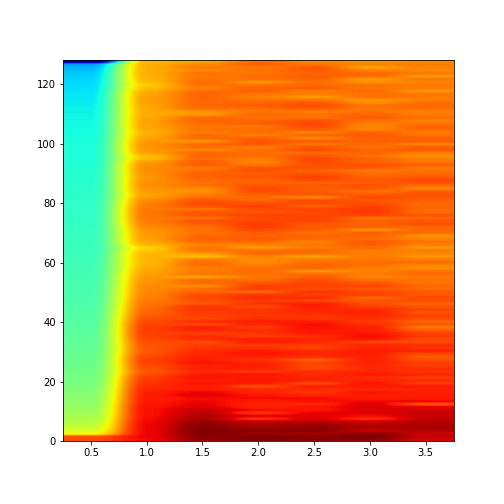

In [14]:
example = test_df['filename'][0]
Image.open(example)

In [15]:
generator = ImageDataGenerator(
  rescale=1./255
)

In [16]:
resnet_train_gen = generator.flow_from_dataframe(
    dataframe=test_df,
    batch_size=batch_size, 
    target_size=resnet152_input_shape, 
    classes=list(labels), 
    shuffle=False)
inception_train_gen = generator.flow_from_dataframe(
    dataframe=test_df,
    batch_size=batch_size, 
    target_size=inceptionV3_input_shape, 
    classes=list(labels), 
    shuffle=False)

Found 780 validated image filenames belonging to 4 classes.
Found 780 validated image filenames belonging to 4 classes.


In [17]:
def test_generator_two_img():
    while True:
        X1i = inception_train_gen.next()
        X2i = resnet_train_gen.next()
        yield [X1i[0], X2i[0]], X1i[1]

## test model

In [18]:
number_of_steps = len(resnet_train_gen.filenames) // batch_size
number_of_steps

260

In [19]:
true_labels = resnet_train_gen.classes

In [20]:
predictions = single_patient_model.predict(test_generator_two_img(), steps=number_of_steps)

2021-10-24 15:24:06.394036: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-24 15:24:06.396090: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-10-24 15:24:07.173097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [21]:
real_number_preds = predictions.argmax(axis=-1)

In [22]:
np.array(true_labels).shape

(780,)

In [23]:
clf_report = classification_report(y_true=true_labels, y_pred=real_number_preds, target_names=labels)

/usr/local/Caskroom/miniforge/base/envs/speciale_01_01/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniforge/base/envs/speciale_01_01/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniforge/base/envs/speciale_01_01/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [24]:
print(clf_report)

              precision    recall  f1-score   support

  Interictal       0.25      0.99      0.40       195
Preictal_One       0.00      0.00      0.00       195
Preictal_Two       0.00      0.00      0.00       195
     Seizure       0.00      0.00      0.00       195

    accuracy                           0.25       780
   macro avg       0.06      0.25      0.10       780
weighted avg       0.06      0.25      0.10       780



In [25]:
labels_as_array = [x for x in labels]
type(labels_as_array[0])

str

In [72]:
confusion_matrix = confusion_matrix(y_true=true_labels, y_pred=list(real_number_preds))

In [73]:
confusion_matrix

array([[194,   1,   0,   0],
       [195,   0,   0,   0],
       [195,   0,   0,   0],
       [193,   2,   0,   0]])

In [74]:
import matplotlib

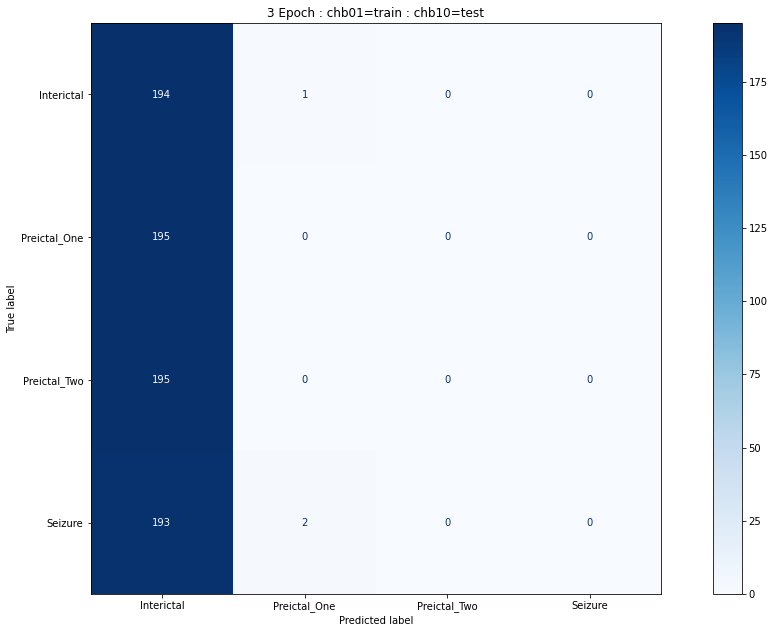

In [75]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels_as_array).plot(cmap='Blues')
plt.title("3 Epoch : chb01=train : chb10=test")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig(external_hardisk_data_path + "hi.png")